# K-Means Clustering

### Introdução
Neste notebook, exploraremos o algoritmo de **K-Means Clustering**, uma técnica poderosa de aprendizagem não supervisionada usada para **agrupar dados** em clusters com base em semelhanças. O K-Means busca minimizar a variância dentro dos clusters, organizando os pontos de dados de forma a revelar padrões subjacentes no conjunto de dados, que, de outra forma, poderiam não ser tão evidentes.

O algoritmo começa selecionando aleatoriamente alguns pontos de dados como "centróides" iniciais. Em seguida, cada ponto de dado é atribuído ao centróide mais próximo, formando agrupamentos iniciais. O processo continua com o recálculo dos centróides com base nos pontos atribuídos e com a realocação dos pontos de dados conforme necessário. Este ciclo se repete até que os centróides se estabilizem e não se movam mais. O resultado final são clusters que agrupam dados semelhantes, facilitando a extração de padrões e insights.

![Gráfico de K-Means Clustering](https://github.com/DSAI-For-Moz/guia-pratico-machine-learning/blob/026c0ff6657fb052a1867e5afa69f0a9d40f0515/images/K-Means.png?raw=true)


### Informação sobre o Conjunto de Dados
O conjunto de dados utilizado foi obtido no [Kaggle](https://www.kaggle.com), e contém características variadas que usamos para agrupar os pontos de dados de forma eficaz. Pode acessar o conjunto de dados [aqui](https://www.kaggle.com/datasets/ilkeryildiz/kmeans-exercise-data). Para simplificar a compreensão e tornar o notebook mais acessível, **nomes fictícios foram criados para as variáveis**, ajudando a focar nos conceitos fundamentais do K-Means sem a complexidade de uma terminologia específica de domínio.

### Objectivo
Aplicar o K-Means Clustering neste contexto tem como objetivo identificar **padrões significativos** dentro do conjunto de dados. Esses padrões podem ajudar a extrair **insights que orientem decisões**, como, por exemplo, a segmentação dos dados para entender diferentes perfis de clientes e melhorar estratégias de marketing.

### Nota
Os nomes fictícios das variáveis têm o objetivo de tornar este notebook mais didático e fácil de seguir para não especialistas. Todos os dados utilizados neste notebook são puramente para **fins de demonstração**.


### Importação das Bibliotecas Necessárias
Nesta seção, importamos as bibliotecas essenciais para a análise de dados e visualização. Vamos utilizar o `numpy` para operações numéricas, `pandas` para manipulação de dados e `matplotlib` para criar gráficos.

Se ainda não tiver instalado as bibliotecas abaixo, remova o `#` e execute a célula abaixo para instalar antes de continuar.

In [12]:
# !pip install numpy pandas matplotlib

In [17]:
# Apresentar as primeiras linhas do conjunto de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x:'%.6f' %x)

### Inicialização dos Parâmetros e Variáveis
Definimos aqui os valores iniciais para a iteração, o número de clusters (k), o ponto de parada, e a semente para garantir a reprodutibilidade dos resultados.

In [20]:
# Inicialização dos parâmetros e variáveis
iteration = 0
number_neighbors = 3
stopping_point = np.ones(2)
np.random.seed(3)

### Leitura e Pré-Processamento dos Dados
Nesta etapa, lemos o dataset e realizamos o pré-processamento, incluindo a remoção de colunas desnecessárias e a adição de uma coluna de previsão inicial.

Os dados foram obtidos no Kaggle. Pode aceder ao conjunto de dados [aqui](https://www.kaggle.com).


In [23]:
# Leitura dos dados e correção do DataFrame a ser processado
file_url = 'https://raw.githubusercontent.com/DSAI-For-Moz/guia-pratico-machine-learning/refs/heads/main/datasets/aprendizagem-nao-supervisionada/1-K-Means.csv'
data = pd.read_csv(file_url)
data.columns = ['Frequência_Visitas_Website', 'Valor_Compras_Trimestrais', 'Valor']
data.drop('Valor', axis=1, inplace=True)
data['Previsão'] = np.random.randint(1, number_neighbors + 1, data.shape[0])

# Apresentar as primeiras linhas do conjunto de dados
data.head()

,Frequência_Visitas_Website,Valor_Compras_Trimestrais,Previsão
0,5.790000,12.470000,3
1,5.430000,11.140000,1
2,5.750000,2.200000,2
3,9.150000,0.140000,1
4,10.380000,0.830000,1


### Inicialização dos DataFrames Auxiliares
Nesta seção, criamos os DataFrames necessários para armazenar informações sobre a função objetivo, valores somados, e visualização inicial dos centroides.

In [26]:
objective_function = pd.DataFrame((np.zeros((data.shape[0], 2))), columns=['Soma', 'Valor'])
values = pd.DataFrame((np.ones((number_neighbors, 9))), columns=['X_Soma', 'Y_Soma', 'Tamanho_Dados', 'X_Média', 'Y_Média', 'X_Média_Antiga', 'Y_Média_Antiga', 'Distância', 'Distância_Centro'])
first_view = pd.DataFrame((np.zeros((3, 5))), columns=['X_Soma', 'Y_Soma', 'Tamanho_Dados', 'X_Média', 'Y_Média'])

### Visualização Inicial dos Dados
Nesta seção, visualizamos a distribuição dos dados antes do processo de clustering. Cada ponto representa um elemento do dataset, colorido de acordo com a sua previsão inicial.

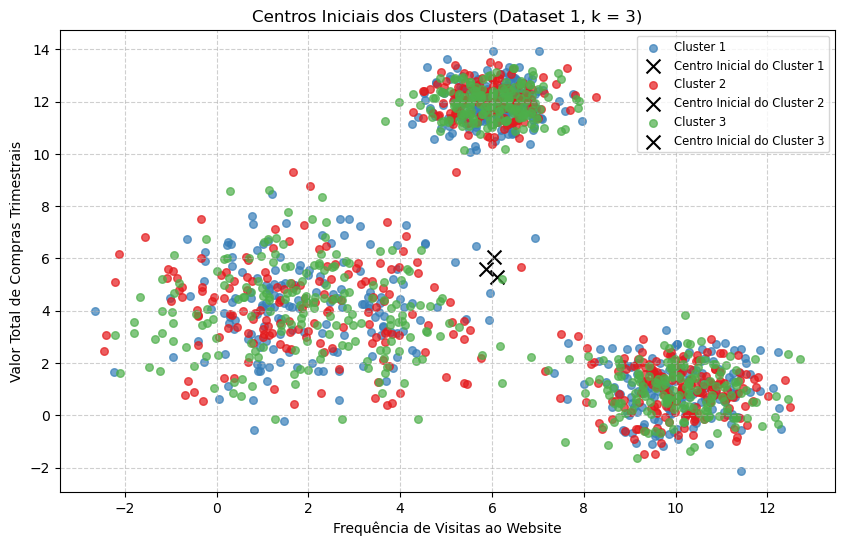

In [33]:
# Definir uma lista de cores mais contrastantes para cada cluster (cores otimizadas para melhor visibilidade)
cores_clusters = ['#377eb8', '#e41a1c', '#4daf4a']  # Azul, Vermelho, Verde

# Visualização dos dados antes do processamento
plt.figure(figsize=(10, 6))
for i in range(0, number_neighbors):
    # Atualizar first_view com os valores iniciais dos clusters
    first_view.iloc[i, 0] = data[data['Previsão'] == i + 1]['Frequência_Visitas_Website'].sum()
    first_view.iloc[i, 1] = data[data['Previsão'] == i + 1]['Valor_Compras_Trimestrais'].sum()
    first_view.iloc[i, 2] = data[data['Previsão'] == i + 1].shape[0] - 1
    first_view.iloc[i, 3] = first_view.iloc[i, 0] / first_view.iloc[i, 2]
    first_view.iloc[i, 4] = first_view.iloc[i, 1] / first_view.iloc[i, 2]

    # Gráfico de dispersão dos dados do cluster
    plt.scatter(data[data['Previsão'] == i + 1]['Frequência_Visitas_Website'], 
                data[data['Previsão'] == i + 1]['Valor_Compras_Trimestrais'],
                color=cores_clusters[i], s=30, alpha=0.7, label=f'Cluster {i + 1}')

    # Gráfico que mostra o centro inicial do cluster com marcador maior
    plt.scatter(first_view.iloc[i, 3], first_view.iloc[i, 4], 
                color="black", marker='x', s=100, label=f'Centro Inicial do Cluster {i + 1}')

# Adicionar rótulos e título
plt.xlabel('Frequência de Visitas ao Website')
plt.ylabel('Valor Total de Compras Trimestrais')
plt.title(f'Centros Iniciais dos Clusters (Dataset 1, k = {number_neighbors})')
plt.grid(True, linestyle='--', alpha=0.6)

# Simplificar a legenda evitando duplicações
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small')

# Mostrar o gráfico
plt.show()


### Interpretação dos Centros Iniciais dos Clusters

Os pontos no gráfico acima representam as observações agrupadas inicialmente. Podemos notar que os centroides iniciais não estão completamente no centro dos grupos de pontos, indicando que o algoritmo K-means ainda precisa ser executado para ajustar esses centros e minimizar a distância total dos pontos ao centro de seus clusters.


### Visualização Final dos Clusters
Aqui, visualizamos os clusters formados após todas as iterações. Cada cluster possui uma cor diferente, e os centroides finais são destacados.

In [37]:
import numpy as np

# Inicializar stopping_point com um valor grande para garantir que o loop inicie
stopping_point = pd.Series([np.inf], index=['Center_Distance'])

# Imprimir o ponto de parada inicial para verificar seu valor antes do loop
print(f"Ponto de parada inicial: {stopping_point.iloc[0]}")

# Inicializar o contador de iterações
iteration = 0
max_iterations = 50  # Definir um limite maior de iterações para convergência, mas seguro

# Inicializar variável para rastrear centroides anteriores
previous_values = pd.DataFrame(np.zeros_like(values), columns=values.columns)

# Realizar todas as operações até atingir o ponto de parada
while stopping_point.iloc[0] > 0.01 and iteration < max_iterations:
    print(f"Iniciando iteração: {iteration}")
    
    # Calcular a soma, a média e os valores centrais para X e Y
    for i in range(1, number_neighbors + 1):
        x = data[data['Previsão'] == i]
        
        # Verificar o tamanho dos dados usados para calcular os centroides
        print(f"Tamanho dos dados para o cluster {i} na iteração {iteration}: {x.shape[0]}")
        
        if x.shape[0] == 0:
            print(f"Aviso: Nenhum ponto atribuído ao cluster {i} na iteração {iteration}")
        
        values.iloc[i-1, 0] = x['Frequência_Visitas_Website'].sum()
        values.iloc[i-1, 1] = x['Valor_Compras_Trimestrais'].sum()
        values.iloc[i-1, 2] = x.shape[0]
        
        if values.iloc[i-1, 2] > 0:
            values.iloc[i-1, 3] = values.iloc[i-1, 0] / values.iloc[i-1, 2]
            values.iloc[i-1, 4] = values.iloc[i-1, 1] / values.iloc[i-1, 2]
        else:
            values.iloc[i-1, 3] = np.nan  # Tratar o caso de cluster vazio
            values.iloc[i-1, 4] = np.nan

    # Imprimir os centroides atualizados após o cálculo
    print(f"Valores (centroides) após atualização dos centroides na iteração {iteration}:")
    print(values)

    # Calcular a distância de cada ponto aos novos centroides e atribuir ao cluster mais próximo   
    for i in range(0, data.shape[0]):
        for j in range(1, number_neighbors + 1):
            values.iloc[j-1, 7] = np.sqrt((data.iloc[i, 0] - values.iloc[j-1, 3])**2 + (data.iloc[i, 1] - values.iloc[j-1, 4])**2)

        # Encontrar o cluster com a menor distância
        min_cluster = values['Distância'].idxmin() + 1
        data.iloc[i, 2] = min_cluster
        
        # Atualizar o valor da função objetivo
        min_distance = values['Distância'].min()
        objective_function.iloc[i, 0] = min_distance**2

    # Imprimir as atribuições dos dados após o cálculo da distância
    print(f"Atribuições de dados após atualização de distância na iteração {iteration}:")
    print(data[['Frequência_Visitas_Website', 'Valor_Compras_Trimestrais', 'Previsão']].head())

    # Calcular a distância em relação ao centro anterior
    for i in range(1, number_neighbors + 1):
        if not np.isnan(values.iloc[i-1, 3]) and not np.isnan(values.iloc[i-1, 5]):
            values.iloc[i-1, 8] = np.sqrt((values.iloc[i-1, 3] - values.iloc[i-1, 5])**2 + (values.iloc[i-1, 4] - values.iloc[i-1, 6])**2)
        else:
            values.iloc[i-1, 8] = 0  # Se houver NaNs, definir a distância como 0 para convergência
        
        # Atualizar o centro antigo para a nova posição
        values.iloc[i-1, 5] = values.iloc[i-1, 3]
        values.iloc[i-1, 6] = values.iloc[i-1, 4]

    # Imprimir o movimento dos centroides após a atualização
    print(f"Valores após atualizar os centroides antigos na iteração {iteration}:")
    print(values)

    # Atualizar o ponto de parada após cada iteração
    stopping_point = values[['Distância_Centro']].max()
    
    # Imprimir o ponto de parada para depuração
    print(f"Ponto de parada após a iteração {iteration}: {stopping_point}")

    # Verificar se os centroides não mudaram significativamente nas últimas iterações
    if np.allclose(previous_values.iloc[:, [5, 6]], values.iloc[:, [3, 4]], atol=0.001):
        print("Convergência alcançada, os centroides não mudaram significativamente.")
        break

    # Atualizar valores anteriores e incrementar a iteração
    previous_values = values.copy()
    iteration += 1

# Se o loop atingir o número máximo de iterações, imprimir uma mensagem
if iteration == max_iterations:
    print("Atingido o número máximo de iterações sem convergência.")


Ponto de parada inicial: inf
Iniciando iteração: 0
Tamanho dos dados para o cluster 1 na iteração 0: 512
Tamanho dos dados para o cluster 2 na iteração 0: 468
Tamanho dos dados para o cluster 3 na iteração 0: 519
Valores (centroides) após atualização dos centroides na iteração 0:
       X_Soma      Y_Soma  Tamanho_Dados  X_Média  Y_Média  X_Média_Antiga  \
0 3088.510000 3096.640000     512.000000 6.032246 6.048125        1.000000   
1 2853.830000 2478.570000     468.000000 6.097927 5.296090        1.000000   
2 3043.920000 2897.580000     519.000000 5.864971 5.583006        1.000000   

   Y_Média_Antiga  Distância  Distância_Centro  
0        1.000000   1.000000          1.000000  
1        1.000000   1.000000          1.000000  
2        1.000000   1.000000          1.000000  
Atribuições de dados após atualização de distância na iteração 0:
   Frequência_Visitas_Website  Valor_Compras_Trimestrais  Previsão
0                    5.790000                  12.470000         1
1         

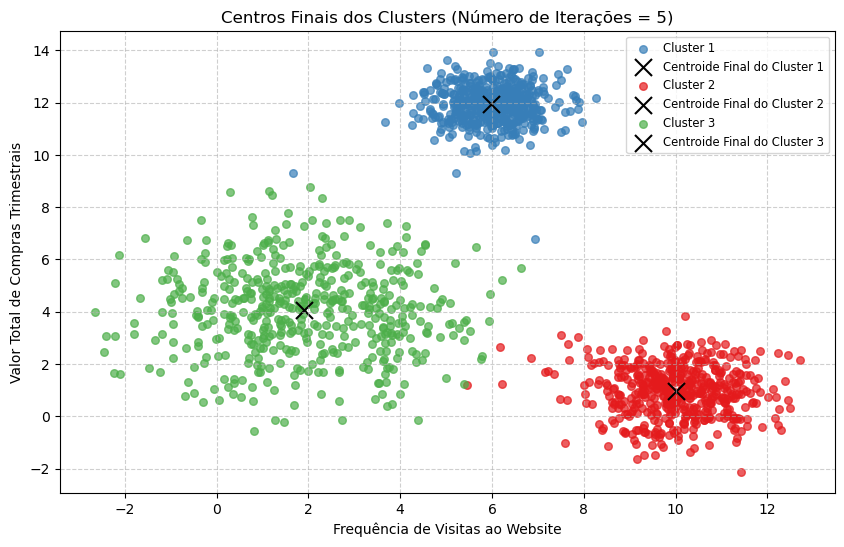

,X_Soma,Y_Soma,Tamanho_Dados,X_Média,Y_Média
0,3005.240000,5993.150000,502.000000,5.986534,11.938546
1,5043.610000,481.690000,504.000000,10.007163,0.955734
2,937.410000,1997.950000,493.000000,1.901440,4.052637


### Interpretação dos Centros Finais dos Clusters

Os pontos e os centroides ajustados mostram o resultado do processo de otimização do algoritmo K-means. Podemos ver que, ao final das iterações, os centroides se encontram no centro dos grupos de pontos, minimizando a distância média de cada ponto ao centro do cluster.

Essa configuração final dos centroides representa os agrupamentos mais estáveis possíveis com o algoritmo, e podemos observar como cada cluster reflete padrões nos dados — por exemplo, podemos notar que certos clusters estão relacionados a diferentes frequências de visitas e valores de compras.


### Implicações de Negócio

A análise dos clusters gerados pelo algoritmo de K-Means revelou três grupos distintos de clientes, cada um com características específicas que impactam as operações e estratégias da empresa.

O primeiro cluster inclui clientes com **alta frequência de visitas ao website e altos valores de compras trimestrais**. Este grupo demonstra um padrão de engajamento elevado tanto em termos de interação quanto de retorno financeiva.

O segundo cluster contém clientes com **frequência moderada de visitas e valores de compras médios**. Esse grupo reflete uma demanda mais estável e menos previsível do que o pripções.

O terceiro cluster envolve clientes que possuem **alta frequência de visitas, mas realizam compras de menor valor**. Apesar do valor das compras ser baixo, a alta frequência de visitas implica um interesse contínuo nos produtos ou srodutos.

A análise desses clusters também contribui para **melhorar a eficiência operacional**. Compreender a distribuição dos clientes nos diferentes clusters permite uma melhor previsão de demanda, ajudando a empresa a dimensionar sua logística de forma clientes.


### Nota
Todos os dados utilizados neste notebook são puramente para **fins de demonstração**.

### Este notebook foi escrito por Simão Rafique

Pode seguir-me no [LinkedIn](https://www.linkedin.com/in/simão-rafique).